In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.python.client import device_lib


In [2]:
# Check if TensorFlow is using a GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("TensorFlow is using the following GPU(s):")
    for gpu in gpus:
        print(gpu)
else:
    print("No GPU detected for TensorFlow.")


No GPU detected for TensorFlow.


In [3]:
import tensorflow as tf
print(tf.__version__)


2.17.0


In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [2]:
# Paths
data_dir = 'data/training'  # Folder with .tif images
csv_file = 'data/training.csv'  # CSV file with image_id and is_homogeneous


In [3]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16


In [4]:
df = pd.read_csv(csv_file)

In [5]:
df

,image_id,is_homogenous
0,279,0
1,277,0
2,275,0
3,273,0
4,271,0
...,...,...
134,9,0
135,7,0
136,5,1
137,3,1


In [6]:
# Strip any leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Now you can access 'image_id' without the extra space
image_id_values = df['image_id'].values
print(image_id_values)


[279 277 275 273 271 269 267 265 263 261 259 257 255 253 251 249 247 245
 243 241 239 237 235 233 231 229 227 225 223 221 219 217 215 213 211 209
 207 205 203 201 199 197 195 193 191 189 187 185 183 181 179 177 175 173
 171 169 167 165 163 161 159 157 155 153 151 149 147 145 143 141 139 137
 135 133 131 129 127 125 123 121 119 117 115 113 111 109 107 105 103 101
  99  97  95  93  91  89  87  85  83  81  79  77  75  73  71  69  67  65
  63  61  59  57  55  53  51  49  47  45  43  41  39  37  35  33  29  27
  25  23  21  19  17  15  13  11   9   7   5   3   1]


In [11]:
def load_and_preprocess_image(image_path):
    # Load image with PIL and convert to an array
    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    # Normalize image pixel values (0-255 -> 0-1)
    img_array = img_array / 255.0
    return img_array

In [10]:
print(df.columns)



Index(['image_id', 'is_homogenous'], dtype='object')


In [7]:
# 3. Create lists of image paths and labels
# Assuming image_id values need to be 3 digits with leading zeros
image_paths = [os.path.join(data_dir, f"{str(image_id).zfill(3)}.tif") for image_id in df['image_id']]
labels = df['is_homogenous'].values

In [9]:
labels


array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0])

In [12]:
# 4. Load images and preprocess them
images = np.array([load_and_preprocess_image(image_path) for image_path in image_paths])



In [13]:
images

array([[[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        ...,

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]],

        [[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.],
         ...,
         [1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]],


       [[[1., 1., 1.],
         [1., 1., 1.],
         [1., 

In [13]:
# 5. Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)


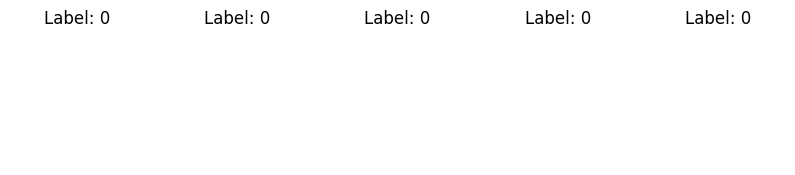

In [14]:
import matplotlib.pyplot as plt

# 5. Select 5 random indices
random_indices = np.random.choice(len(images), 5, replace=False)

# 6. Plot the images with their corresponding labels
plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[idx])
    plt.title(f"Label: {labels[idx]}")
    plt.axis('off')  # Hide axis
plt.show()


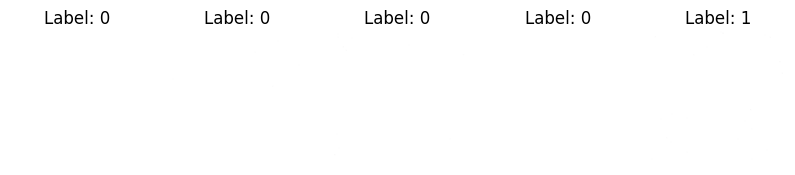

In [15]:
def load_and_preprocess_image(image_path):
    # Load image with PIL and convert to an array
    img = load_img(image_path, target_size=IMG_SIZE)
    img_array = img_to_array(img)
    return img_array  # Do not normalize yet

# Reload and display images
images = np.array([load_and_preprocess_image(image_path) for image_path in image_paths])

# Display random 5 images without normalization
random_indices = np.random.choice(len(images), 5, replace=False)

plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[idx].astype('uint8'))  # Convert back to integer pixel values
    plt.title(f"Label: {labels[idx]}")
    plt.axis('off')
plt.show()



In [16]:
# Check if the paths are correct
print(image_paths[:5])  # Print the first 5 image paths to verify


['data/training/279.tif', 'data/training/277.tif', 'data/training/275.tif', 'data/training/273.tif', 'data/training/271.tif']


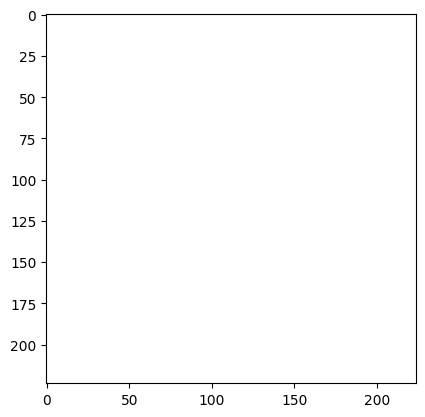

In [17]:
image_path = image_paths[0]  # Pick the first image path
img = load_img(image_path, target_size=IMG_SIZE)
img_array = img_to_array(img)
plt.imshow(img_array.astype('uint8'))
plt.show()



In [19]:
from PIL import Image

# Load with PIL and check image details
image = Image.open(image_path)
print(image.format, image.mode, image.size)
image.show()  # This opens the image in the default image viewer


TIFF I;16B (711, 639)


In [14]:
# Assuming y_train is a NumPy array of labels
# Separate majority and minority class samples
X_train_majority = X_train[y_train == 0]  # Majority class (e.g., Heterogeneous)
y_train_majority = y_train[y_train == 0]

X_train_minority = X_train[y_train == 1]  # Minority class (e.g., Homogeneous)
y_train_minority = y_train[y_train == 1]

print(f"Majority class samples: {len(y_train_majority)}")
print(f"Minority class samples: {len(y_train_minority)}")


Majority class samples: 91
Minority class samples: 20


In [15]:
# Data augmentation parameters for the minority class
minority_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)


In [16]:
# Calculate how many augmented images we need
num_majority_samples = len(y_train_majority)
num_minority_samples = len(y_train_minority)
num_augmented_images_needed = num_majority_samples - num_minority_samples

print(f"Number of augmented images needed: {num_augmented_images_needed}")


Number of augmented images needed: 71


In [17]:
# Reshape X_train_minority for the generator
X_train_minority = X_train_minority.reshape((-1, IMG_SIZE[0], IMG_SIZE[1], 3))

# Create a generator for the minority class
minority_generator = minority_datagen.flow(
    X_train_minority,
    y_train_minority,
    batch_size=1,
    shuffle=False
)

# Generate augmented images
X_augmented = []
y_augmented = []

for i in range(num_augmented_images_needed):
    X_batch, y_batch = next(minority_generator)
    X_augmented.append(X_batch[0])
    y_augmented.append(y_batch[0])

# Convert to NumPy arrays
X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

print(f"Augmented images generated: {len(y_augmented)}")


Augmented images generated: 71


In [18]:
# Combine original minority data with augmented data
X_minority_balanced = np.concatenate([X_train_minority, X_augmented])
y_minority_balanced = np.concatenate([y_train_minority, y_augmented])

# Combine with majority class data
X_train_balanced = np.concatenate([X_train_majority, X_minority_balanced])
y_train_balanced = np.concatenate([y_train_majority, y_minority_balanced])

print(f"Balanced training samples: {len(y_train_balanced)}")


Balanced training samples: 182


In [19]:
from sklearn.utils import shuffle

X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)


In [20]:
# Data generator for the balanced dataset (minimal augmentation)
train_datagen_balanced = ImageDataGenerator(
    rescale=1./255  # Normalize pixel values
)

train_generator = train_datagen_balanced.flow(
    X_train_balanced, y_train_balanced, batch_size=BATCH_SIZE
)

# Validation data generator (normalize)
val_datagen = ImageDataGenerator(
    rescale=1./255
)

val_generator = val_datagen.flow(
    X_val, y_val, batch_size=BATCH_SIZE
)


In [ ]:
# 6. Create data generators for augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [ ]:
val_datagen = ImageDataGenerator()


In [ ]:
# 7. Create the data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
val_generator = val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)


In [21]:
# 8. Load the pre-trained VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


In [22]:
for layer in base_model.layers:
    layer.trainable = False

In [23]:
# 10. Create the model by adding custom layers on top of the pre-trained base model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Add dropout for regularization
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

In [24]:
# 11. Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [25]:
# 12. Train the model
history = model.fit(
    train_generator,
    epochs=30,  # Adjust the number of epochs as needed
    validation_data=val_generator
)

Epoch 1/30


/Users/costelgutu/Projects/DM-i-AI-2024/cell-classification/.cellclass/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5037 - loss: 0.7379 - val_accuracy: 0.1429 - val_loss: 0.7007
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.4763 - loss: 0.7758 - val_accuracy: 0.1429 - val_loss: 0.7076
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5390 - loss: 0.7301 - val_accuracy: 0.1429 - val_loss: 0.6969
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.4630 - loss: 0.7517 - val_accuracy: 0.1429 - val_loss: 0.6938
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.5421 - loss: 0.7423 - val_accuracy: 0.1429 - val_loss: 0.6954
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.4669 - loss: 0.7627 - val_accuracy: 0.1429 - val_loss: 0.6932
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5111 - loss: 0.7458 - val_accuracy: 0.1429 - val_loss: 0.7050
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.5281 - loss: 0.7121 - val_accuracy: 0.1429 - val_loss: 0.6972
Epo

In [26]:
# 13. Evaluate the model on the validation set
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc*100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 922ms/step - accuracy: 0.8631 - loss: 0.6794
Validation Accuracy: 85.71%


In [ ]:
model.save('vgg16_homogeneous_classification.h5')


In [ ]:
from tensorflow.keras.models import load_model


In [ ]:
model1 = load_model('vgg16_homogeneous_classification.h5')  # Path to your saved model


In [29]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8571 - loss: 0.6875


In [30]:
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')

Validation Loss: 0.687531054019928
Validation Accuracy: 85.71%


In [31]:
predictions = model.predict(X_val)
predicted_labels = (predictions >= 0.5).astype(int)  # Threshold at 0.5 to get binary labels


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [32]:
from sklearn.metrics import classification_report


In [33]:
print(classification_report(y_val, predicted_labels, target_names=['Heterogeneous', 'Homogeneous']))


               precision    recall  f1-score   support

Heterogeneous       0.86      1.00      0.92        24
  Homogeneous       0.00      0.00      0.00         4

     accuracy                           0.86        28
    macro avg       0.43      0.50      0.46        28
 weighted avg       0.73      0.86      0.79        28



/Users/costelgutu/Projects/DM-i-AI-2024/cell-classification/.cellclass/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/costelgutu/Projects/DM-i-AI-2024/cell-classification/.cellclass/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/costelgutu/Projects/DM-i-AI-2024/cell-classification/.cellclass/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. U

In [34]:

# Assuming y_val contains the true labels and predicted_labels contains the predicted labels

# Step 1: Calculate n_0 and n_1
n_0 = np.sum(y_val == 0)  # Number of true heterogeneous cells
n_1 = np.sum(y_val == 1)  # Number of true homogeneous cells

# Step 2: Calculate a_0 and a_1
a_0 = np.sum((y_val == 0) & (predicted_labels == 0))  # Correctly predicted as heterogeneous
a_1 = np.sum((y_val == 1) & (predicted_labels == 1))  # Correctly predicted as homogeneous

# Step 3: Calculate the score
if n_0 == 0 or n_1 == 0:
    score = 0  # Handle edge cases where there are no samples of a class
else:
    score = (a_0 * a_1) / (n_0 * n_1)

print(f'Score: {score}')


Score: 0.0


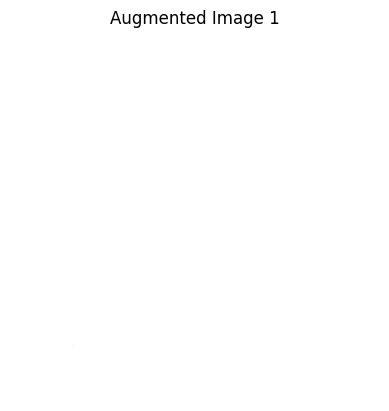

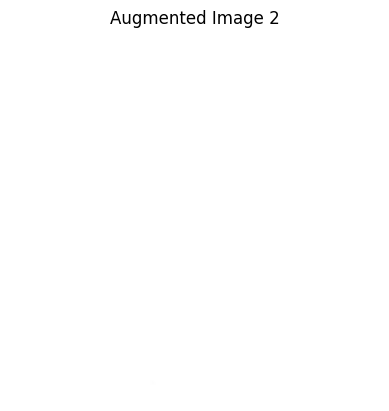

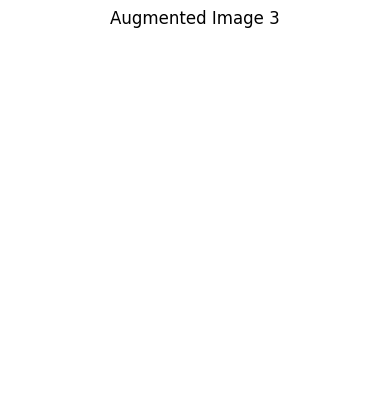

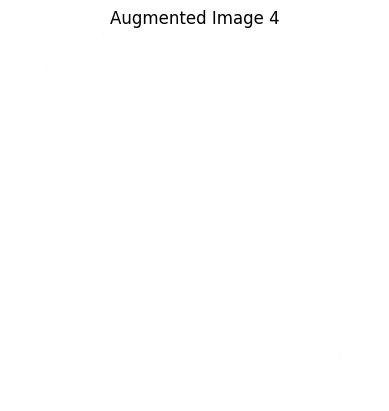

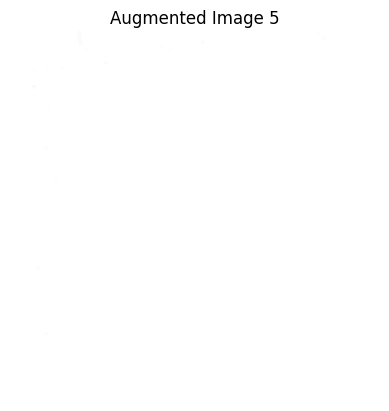

In [37]:
import matplotlib.pyplot as plt

# Display some augmented images
num_images_to_display = 5
for i in range(num_images_to_display):
    plt.imshow(X_augmented[i])
    plt.title(f"Augmented Image {i+1}")
    plt.axis('off')
    plt.show()



